In [211]:
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

In [212]:
train_csv = pd.read_csv('train.csv')

In [213]:
#train_csv.head()
#train_csv.info()
#train_csv.describe()

In [214]:
train_labels = train_csv['label']
train_csv.drop('label',axis =1, inplace =True)
train_features = train_csv
train_features = train_features.values.reshape(-1,1,28,28)
train_labels = train_labels.values

In [215]:
#train_features.shape
#train_labels.shape
#train_labels[0:4]

In [216]:
test_csv = pd.read_csv('test.csv')
#test_csv.info()
#test_csv.describe()
#test_csv.head()
test_features = test_csv.values.reshape(-1,1,28,28)
test_features.shape

(28000, 1, 28, 28)

In [217]:
def show_fashion_mnist(images, labels, figsize=(12,12),size = 10):
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, size, figsize=figsize)
    for f, i, j in zip(figs, range(size), range(size)):
        f.imshow(images[i][0,:,:])
        f.set_title(labels[j])
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

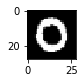

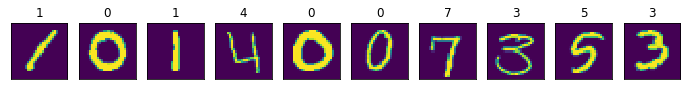

In [218]:
plt.figure(figsize=(0.9,0.9))
plt.imshow(train_features[1][0,:,:],cmap='gray')
plt.show()
show_fashion_mnist(train_features, train_labels)

In [219]:
#batch_size =256
#train_features = torch.tensor(train_features,dtype = torch.float)
#train_labels = torch.tensor(train_labels, dtype = torch.float)
#test_features = torch.tensor(test_features, dtype = torch.float)

In [220]:
len(train_features)

42000

# 网络层

In [221]:
def Flatten(x):
    return x.view(1,-1)

class net(nn.Module):
    def __init__(self):
        super(net,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), #b*1*28*28  =>b*6*28*28
            nn.Sigmoid(),                                                       
            nn.AvgPool2d(kernel_size=2, stride=2),                              #b*6*28*28  =>b*6*14*14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),           #b*6*14*14  =>b*16*10*10
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)                               #b*16*10*10  => b*16*5*5
            )   
        self.dense = nn.Sequential(
            Flatten(),                                                              #b*16*5*5   => b*400
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
            )
    def forward(x):
        return self.dense(self.conv(x))

# 训练模型

In [222]:
def train(net, train_features,train_labels, test_features, test_labels, 
                  num_epochs,batch_size,lr,weight_decay,criterion ):
    optimizer = torch.optim.Adam(params = net.parameter(), lr = lr, weight_decay = weight_decay)
    train_dataset = torch.util.data.TensorDataset(train_features,train_labels)
    train_iter = torch.util.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    for x , y in train_iter:
        net.train()
        y_hat = net(x)
        loss = criterion(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# K折

In [225]:
def get_k_fold(i,k,train_features, train_labels):
    fold_size = len(train_features)//k
    features_train, labels_train = None,None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        features_part , labels_part = train_features[idx,:,:,:],train_labels[idx]
        if i == j:
            features_valid,labels_valid = features_part, labels_part
        elif features_train is not None:
            features_train, labels_train = features_part,labels_part
        else :
            features_train = torch.cat((features_train,features_part),dim =0 )
            labels_train = torch.cat((labels_train, labels_part),dim = 0)
    return features_train,labels_train, features_valid , labels_valid